In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Industry variety
data ref: Ravenna, June 2015  
data source: [Ravenna opendata](https://opendata.comune.ra.it/organization/comune-ravenna)  

**Indicator**: the aim of this indicator is to evaluate industry variety and distribution in each district.  
**Limitations**: companies' identifier codes are by physical office and VAT isn't provided in the open data, thus duplicates are removed by name to count the presence and types of economic activities; outdated data.

## Prepare data

                                            geometry  frazione
0  POLYGON ((284232.269 4930649.527, 284235.500 4...  DEL MARE


<AxesSubplot:>

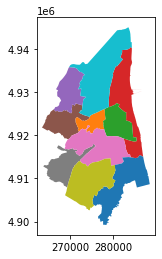

In [2]:
zone = gpd.read_file( './data/aree.geojson' )
zone = zone[["geometry", "NOME_AT"]] # shows epsg:3004, but it's wrong
zone = zone.rename(columns = { "NOME_AT" : "frazione" })
zone = zone.set_crs( "epsg:4326", allow_override = True )
zone = zone.to_crs( epsg = 32633 ) #utm
print(zone.head(1))
zone.plot( column = "frazione" )

In [3]:
ateco = pd.read_csv( './data/ateco.csv', encoding = 'ISO-8859-1' ) # ateco classification of economic activities
print(ateco.head(2))

  ateco_cod                                         ateco_nome
0         U      Organizzazioni ed organismi extraterritoriali
1         T  Attività di famiglie e convivenze come datori ...


In [4]:
companies = gpd.read_file('./data/imprese.geojson')
companies = companies[['DENOMINAZI', 'geometry', 'CODICE_ATT']]
companies = companies.to_crs( epsg = 32633 ) # utm
companies = companies.rename( columns = { 'DENOMINAZI' : 'nome', 'CODICE_ATT' : 'ateco' } )
companies = companies.dropna( subset = ['ateco'] ) # delete unspecified companies
companies['ateco'] = companies['ateco'].str.replace( '[A-Z]', '', regex = True ) # the default value of regex will change from True to False in a future version
companies['ateco'] = companies['ateco'].str.replace(' ', '')
companies_ateco = companies['ateco'].str.split( '/', expand = True )
companies_ateco = companies_ateco.add_prefix( 'ateco_' )
companies = companies.drop( columns = ['ateco'] )
companies = pd.concat( [companies, companies_ateco], axis = 1 )
print(companies.head(2))

                                                nome  \
0        CASADIO & VANNINI DI GALLI ALBA E C. S.N.C.   
1  HOTEL BISANZIO-DI FABBRI DONATELLA & C.-SOCIET...   

                         geometry  ateco_0  ateco_1 ateco_2 ateco_3 ateco_4  \
0  POINT (272167.050 4922066.166)  45.20.2  45.20.1   77.11    None    None   
1  POINT (276997.507 4922289.211)     55.1     None    None    None    None   

  ateco_5 ateco_6  
0    None    None  
1    None    None  


check number of values by column

In [5]:
# occurrences_0 = companies['ateco_0'].value_counts() # == 897
# occurrences_1 = companies['ateco_1'].value_counts() # == 702
# occurrences_2 = companies['ateco_2'].value_counts() # == 501
# occurrences_3 = companies['ateco_3'].value_counts() # == 348
# occurrences_4 = companies['ateco_4'].value_counts() # == 249
# occurrences_5 = companies['ateco_5'].value_counts() # == 150
# occurrences_6 = companies['ateco_6'].value_counts() # == 13
# print(occurrences_0)

In [6]:
companies = companies[['nome', 'geometry', 'ateco_0']]
companies = companies.rename( columns = { 'ateco_0' : 'ateco_cod' } )
ateco = ateco.drop_duplicates( subset = ['ateco_cod'] ) # companies rows will increase if keys match more than one row in the other df
companies = pd.merge( companies, ateco, how = 'left', on = 'ateco_cod' )
# error = companies[companies['ateco_nome'].isna()] # look for untranslated ateco_cod values
print(companies.head(2))

                                                nome  \
0        CASADIO & VANNINI DI GALLI ALBA E C. S.N.C.   
1  HOTEL BISANZIO-DI FABBRI DONATELLA & C.-SOCIET...   

                         geometry ateco_cod  \
0  POINT (272167.050 4922066.166)   45.20.2   
1  POINT (276997.507 4922289.211)      55.1   

                                  ateco_nome  
0  Riparazione di carrozzerie di autoveicoli  
1                Alberghi e strutture simili  


### Distribution

In [7]:
distribution = zone.overlay( companies, how = 'intersection', keep_geom_type = False )
distribution = distribution.drop_duplicates( subset = ['nome'], ignore_index = True )
distribution = distribution.drop( columns = ['nome', 'ateco_nome', 'geometry'] )
# print(distribution.head(2))

In [8]:
distribution = distribution.rename( columns = { 'ateco_cod' : 'companies' } ) # prepare column for count
distribution = distribution.groupby('frazione').count().reset_index()
distribution = distribution.merge( zone, on = 'frazione' )
# print(isinstance(distribution, gpd.GeoDataFrame))
distribution = gpd.GeoDataFrame(distribution)
distribution['areas'] = distribution['geometry'].area  / 10**6 # kmq
distribution['industry_density'] = round( distribution['companies'] / distribution['areas'], 2 )
print(distribution.head(2)) # ready for indicators df

        frazione  companies  \
0    CASTIGLIONE        978   
1  CENTRO URBANO       3885   

                                            geometry      areas  \
0  POLYGON ((286726.373 4915066.675, 286750.492 4...  80.437160   
1  POLYGON ((278046.280 4925082.213, 278051.049 4...  21.155808   

   industry_density  
0             12.16  
1            183.64  


### Variety

In [9]:
variety = companies
variety['ateco_cod'] = variety['ateco_cod'].str.split( pat = '.' )
variety['ateco_cod'] = variety['ateco_cod'].str.get(0)

In [10]:
variety_tot = variety[['geometry', 'ateco_cod']].groupby('ateco_cod').count().reset_index()
variety_tot = variety_tot.rename(columns = { 'geometry' : 'tot' })
variety_tot = pd.merge( variety_tot, ateco, how = 'left', on = 'ateco_cod' )
variety_tot = variety_tot[['ateco_nome', 'tot']]

Districts breakdown

In [11]:
variety_local = zone.overlay( variety, how = "intersection", keep_geom_type = False )
variety_local = variety_local.drop_duplicates( subset = ['nome'], ignore_index = True )
variety_local = variety_local.groupby('frazione')
# print(variety_local.head(3)) # shows the first three of each group
print( variety_local.get_group('DEL MARE').head(2) )

   frazione                                               nome ateco_cod  \
0  DEL MARE  FERRAMENTA ZANGAGLIA DI PAOLO E CLAUDIO ZANGAG...        47   
1  DEL MARE  ASSOCIAZIONE COOPERATIVA MURATORI & AFFINI RAV...        41   

                                          ateco_nome  \
0  Empori ed altri negozi non specializzati di va...   
1  Costruzione di edifici residenziali e non resi...   

                         geometry  
0  POINT (283771.377 4929581.233)  
1  POINT (284620.355 4924355.829)  


In [12]:
variety_data = pd.DataFrame( columns = ['frazione', 'types'] ) # ready for indicator df

def distr_analysis(df_input, str_input):
    df = df_input[['ateco_cod', 'nome']]
    df = df.groupby('ateco_cod').count().reset_index()
    global variety_data
    d = { 'frazione' : [str_input], 'types' : [len(df.index)] }
    df_temp = pd.DataFrame(data = d)
    variety_data = pd.concat( [variety_data, df_temp], ignore_index = True )
    return

for name, group in variety_local:
    distr_analysis( group, name )

## Municipality indicators

In [13]:
ra = pd.DataFrame()
ra['companies'] = [ companies.shape[0] ]
ra['area'] = [ zone['geometry'].area.sum() / 10**6 ] # kmq
ra['industry_density'] = round( ra['companies'] / ra['area'], 2 )
ra['types'] = [ variety_tot.shape[0] ]
ra['industry_variety'] = round( ra['companies'] / ra['types'], 2 )
print(ra)

   companies        area  industry_density  types  industry_variety
0      16094  652.620185             24.66     80            201.18


Total Top 10 types of companies


<AxesSubplot:ylabel='ateco_nome'>

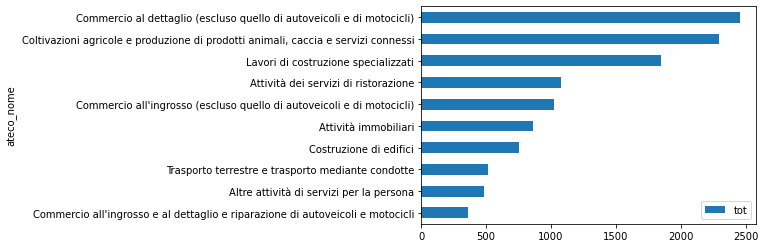

In [14]:
variety_tot['tot'] = variety_tot['tot'].nlargest(n = 10) # mask top 10
variety_tot = variety_tot.dropna( subset = ['tot'] ) # keep top 10
variety_tot = variety_tot.sort_values( by = ['tot'] )
print('Total Top 10 types of companies')
variety_tot.plot.barh( x = 'ateco_nome', y = 'tot' )

## Districts indicators

        frazione  companies  \
0    CASTIGLIONE        978   
1  CENTRO URBANO       3885   

                                            geometry      areas  \
0  POLYGON ((286726.373 4915066.675, 286750.492 4...  80.437160   
1  POLYGON ((278046.280 4925082.213, 278051.049 4...  21.155808   

   industry_density  types  industry_variety  
0             12.16     50         19.560000  
1            183.64     73         53.219178  


Text(0.5, 1.0, 'Industry Variety')

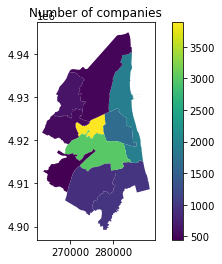

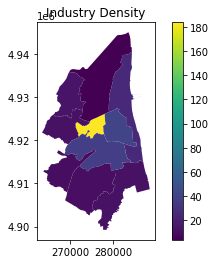

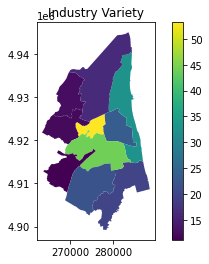

In [15]:
indicators = pd.merge( distribution, variety_data, on = 'frazione' )
indicators['industry_variety'] = indicators['companies'] / indicators['types']
# print(isinstance(indicators, gpd.GeoDataFrame))
indicators = gpd.GeoDataFrame(indicators)
# print(indicators['types'].dtype) # object
indicators['types'] = pd.to_numeric(indicators['types'])
indicators['industry_variety'] = pd.to_numeric(indicators['industry_variety'])
print(indicators.head(2))
indicators.plot( column = 'companies', legend = True )
plt.title('Number of companies')
indicators.plot( column = 'industry_density', legend = True )
plt.title('Industry Density')
indicators.plot( column = 'industry_variety', legend = True )
plt.title('Industry Variety')

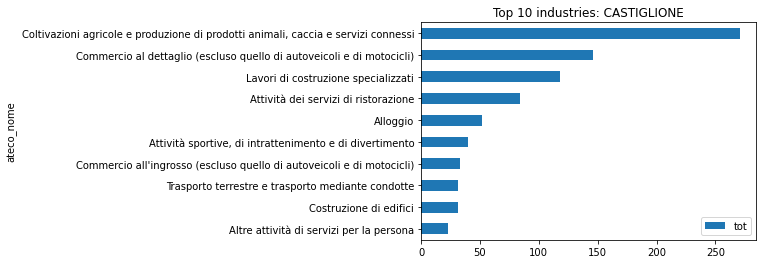

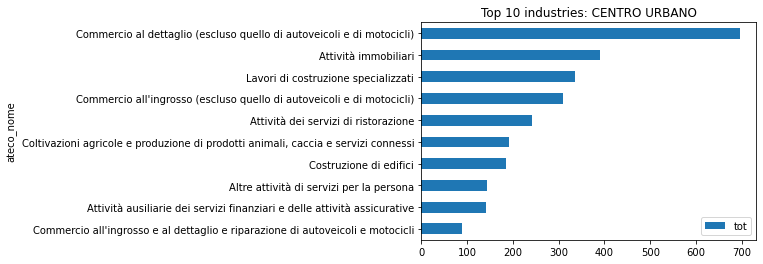

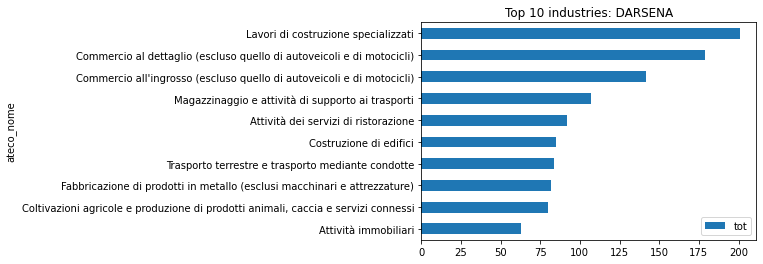

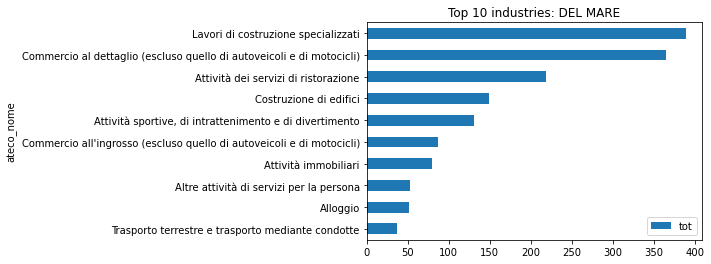

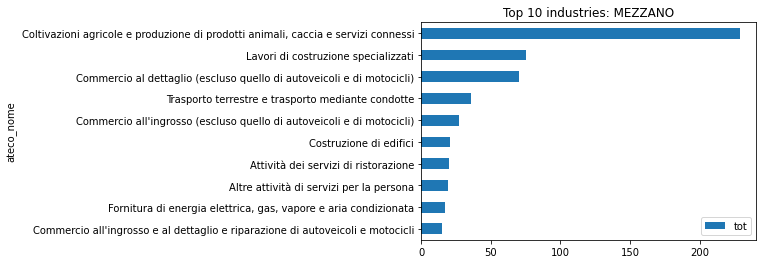

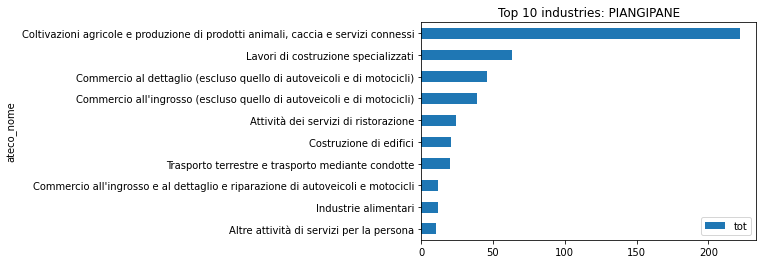

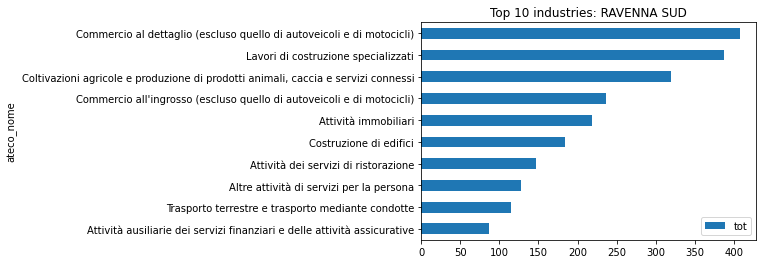

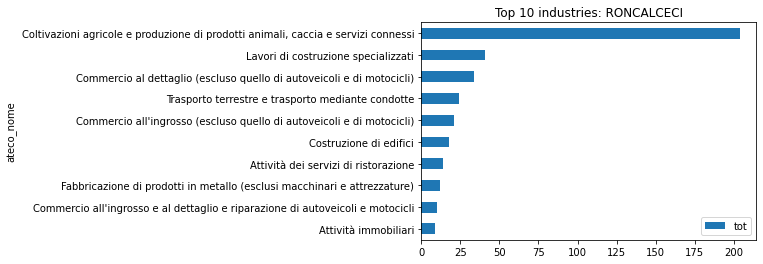

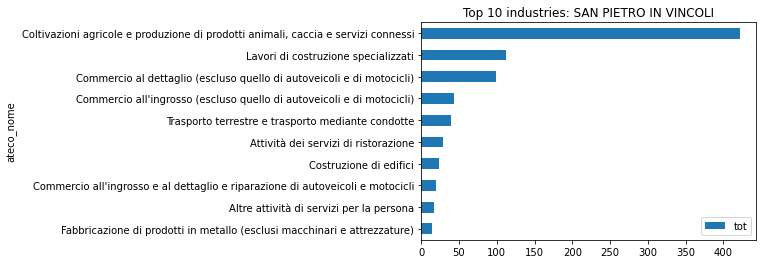

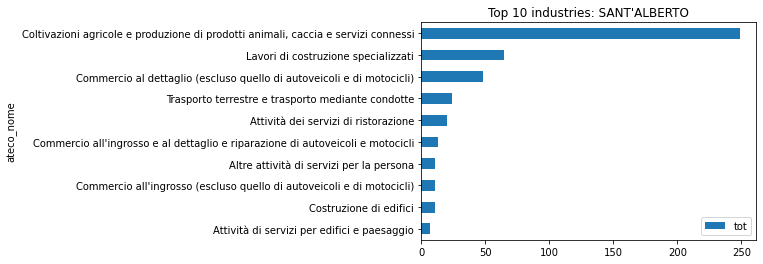

In [16]:
def distr_top(df_input, str_input):
    df = df_input[['ateco_cod', 'nome']]
    df = df.groupby('ateco_cod').count().reset_index()
    df = df.rename( columns = { 'nome' : 'tot' } )
    df = pd.merge( df, ateco, how = 'left', on = 'ateco_cod' )
    df = df[['ateco_nome', 'tot']]
    df['tot'] = df['tot'].nlargest(n = 10) # mask top 10
    df = df.dropna( subset = ['tot'] ) # keep top 10
    df = df.sort_values( by = ['tot'] )
    df.plot.barh( x = 'ateco_nome', y = 'tot', title = str_input)
    plt.title('Top 10 industries: ' + str_input)
    return

for name, group in variety_local:
    distr_top(group, name)